# Image Filtering Module: Fourier Transform as Change of Basis

**Notes from Hany Farid's Computer Vision Course (UC Berkley)**
https://farid.berkeley.edu/downloads/tutorials/learnComputerVision/

In [7]:
# Imports for this notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.signal import sepfir2d

## Basis and Fourier

### Canonical Basis

We have been talking about vectors assuming a canonical basis - which is to say that if we have a 2 dimensional space we typically assume that our two basis vectors ($\hat i$ and $\hat j$) are 1 along the relevant axis and everything else is 0. 

So, the basis vector $\hat i$ in the x direction is (1,0) and the basis vector $\hat j$ in the y direction is (0,1). See the ["Change of Basis" video from 3Blue1Brown's Essence of Linear Algebra series](https://www.youtube.com/watch?v=P2LTAUO1TdA&list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab&index=13) for more intuition on that.

If we have a series of signals $[1,2,3,4,5,6,7]$, we assume that they map to a sum of "scaled and shifted impulses" - these are assumed to be using canonical basis:

```
1(1 0 0 0 0 0 0)
2(0 1 0 0 0 0 0)
3(0 0 1 0 0 0 0)
4(0 0 0 1 0 0 0)
5(0 0 0 0 1 0 0)
6(0 0 0 0 0 1 0)
7(0 0 0 0 0 0 1)
```

So our equation for a discrete signal can then be represented as a sum of some scaled and shifted impulses where $a_k$ is the scalar value we see above (1,2,3...7) and $b_k$ is the degree to which our impulse is shifted (as seen in the vectors above):

$f[x] = \sum\limits_{k=0}^{m-1} a_k b_k(x) $


But how do we find $a_k$? We just need to take the dot product between our input signal and corresponding basis vector:

$ a_k = \sum\limits_{l=0}^{m-1} f(l) b_k(l) $


### Fourier Series & Transform

Though we typically assume canonical basis when discussing vectors (as seen above), it's really just a convenient representation - but we can choose to use any basis we want instead of the canonical basis. 

In the Fourier series we use a $cos$ basis in the form of:

$f[x] = \frac{1}{m}
\sum\limits_{k=0}^{m-1} 
c_k \cos \bigg{(}
\frac{2 \pi k}{m} x + \phi_k \bigg{)}$

In the above expression we are describing our discrete series $f[x]$ with three important terms:

- **Frequency:** 
$\frac{2 \pi k}{m} $ above ... but this is more often represented as **$w_k x$**

- **Phase:** 
$\phi_k$ (phase shifted cosines are sinusoidal)

- **Amplitude:** 
$c_k$ (scale of cosine or sine function)

---
#### Fixing our basis

The problem is that our phase term $\phi_k$ aparently leaves us with a non-fixed basis because it is dependent on $k$ (each discrete signal) and we don't want that so we need a way to fix our basis

We can fix this by using the following trig identity:

$\cos(A+B) = \cos(A)\cos(B) - \sin(A)\sin(B)$

So the above equation can now be represented as:

$f[x] = \frac{1}{m}
\sum\limits_{k=0}^{m-1} 
c_k \cos(\phi_k) \cos(\omega_k x)- c_k \sin(\phi_k)(\sin(\omega_k x)$

But because the $\cos(\phi_k)$ and $-\sin(\phi_k)$ are just scale factors we can bundle them up with our other $c_k$ scale term (the amplitude) as $a_k$ and $b_k$ respectively:

$f[x] = \frac{1}{m}
\sum\limits_{k=0}^{m-1} 
a_k \cos(\omega_k x) + b_k(\sin(\omega_k x)$

*Note*: It sounds like the negative sign introduced in the trig identity for cosine has been absorbed into the $b_k$ term above

So now we've managed to pull our phase term $\phi_k$ out of the basis and into the scale term so our basis itself can remain fixed across each impulse in our discrete signal. But we have two fixed basis - the $\cos(\omega_k x)$ and $\sin(\omega_k x)$ terms - that we need to carry around

#### Questions:

- Looking at the following Fourier expression, why does the $_k$ in our phase term ($\phi_k$) create the non-fixed basis problem but the $_k$ in our frequency term ($\omega_k x$) does not? Put another way, how can I build intuition for the fact that we have a fixed basis when frequency modulated but a non-fixed basis when phase modulated?

$f[x] = \frac{1}{m}
\sum\limits_{k=0}^{m-1} 
c_k \cos(\omega_k x + \phi_k)$


---
### Fourier in 2D

We can similarly compute the Fourier transform in 2 dimensions, now with a double sum over every pixel in the image (in our case)

$f[x,y] = \frac{1}{m^2}
\sum\limits_{k=0}^{m-1} 
\sum\limits_{l=0}^{m-1}
c_{kl} \cos(\omega_k x + \omega_l y + \phi_{kl})$

But we have to do same thing we did above to remove the phase term $\phi_{kl}$ from the cos term to avoid having our basis changed every time we evaluate a pixel in the image. This leaves us with:

$f[x,y] = \frac{1}{m2}
\sum\limits_{k=0}^{m-1}
\sum\limits_{l=0}^{m-1}
a_{kl} \cos(\omega_k x + \omega_l y) + 
b_{kl}\sin(\omega_k x + \omega_l y)$

The above is now a statement that we can understand our discrete series with two basis which are frequency modulated but not phase modulated - though we still need to know how to find our scalar values $a_{kl}$ and $b_{kl}$!

We can do this by taking the dot product of the image (all pixel values) and the cos or sin basis:

$ a_{kl} = \sum\limits_{k=0}^{m-1}
\sum\limits_{l=0}^{m-1}
f[u,v] \cos(\omega_k u + \omega_l v)$

$ b_{kl} = \sum\limits_{k=0}^{m-1}
\sum\limits_{l=0}^{m-1}
f[u,v] \sin(\omega_k u + \omega_l v)$

#### Complex Exponential Representation
We can express the same statement above with a complex exponential instead of the cos term originally used:

$ f[x,y] = \frac{1}{m2}
\sum\limits_{k=0}^{m-1}
\sum\limits_{l=0}^{m-1}
c_{kl} e^{i(\omega_k x + \omega_l y)}$

And our new scale term, $c_{kl}$ can be found by taking the difference between $a_{kl}$ and $ib_{kl}$:

$ c_{kl} = a_{kl} - ib_{kl} = 
\sum\limits_{k=0}^{m-1}
\sum\limits_{l=0}^{m-1}
f[u,v] e^{i(\omega_k u + \omega_l v)}$

### Exercise #8 - Compute the log of the magnitude of the Fourier transform

> Write some code to compute the log of the magnitude of the Fourier transform of a grayscale image.

> See `numpy.fft.fft2` (note, origin of fft will be in top-left corner, see also `numpy.fft.fftshift` to place the origni in the image center).

Some verbal instructions:
1. Take a gray-scale image
2. Take the Fourier transform
3. Compute the magnitude (sqrt of the "cosine term" + "imaginary/sine term")
4. Take the log of the magnitude above

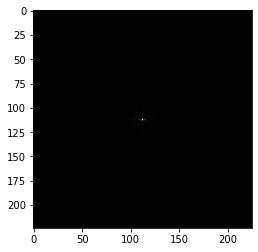

In [8]:
# I'll re-use our einstein image and convert it to a single channel again
img_raw = 1.0 * plt.imread('../images/einstein.jpeg')
img = np.average(img_raw, axis=-1)

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
fmag = np.abs(fshift[:,:])
plt.imshow(fmag, cmap="gray")

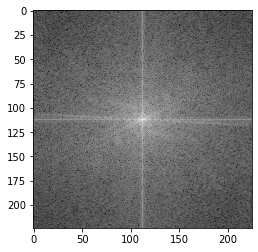

In [9]:
# Now let's plot the log of the magnitude
fmaglog = np.log(fmag)
plt.imshow(fmaglog, cmap="gray")

The problem log of the Fourier magnitude above would suggest strong vertical and horizontal shifts in the image (which is not the case in our image!)

It turns out this is an artifact because the Fourier transformation assumes the image/signal is periodic... which our image isn't (the top values do not match the bottom, same with left to right). So the strong lines we see are due to the fact that we have the cut-offs at the edges of our image which do not match up when you wrap it around in a continuous fashion. 

Hany shows us how to account for that by creating hanning windows, as in his solution below:

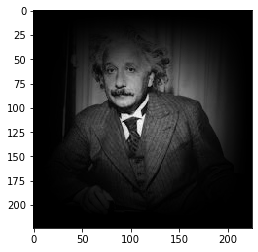

In [10]:
[ydim,xdim] = img.shape
win = np.outer( np.hanning(ydim), np.hanning(xdim))
win = win / np.mean(win) # make unit-mean

win_img = img*win
plt.imshow(win_img, cmap='gray')

This window supresses values at the edges of the image down to 0 so that it forces periodicity in the image overall. Now we can take the magnitude and log(magnitude)

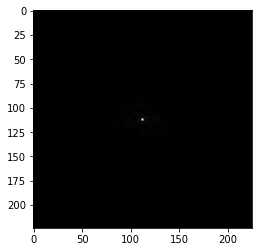

In [11]:
F = np.fft.fftshift(np.fft.fft2(win_img))
Fmag = np.abs(F)
plt.imshow(Fmag, cmap='gray')

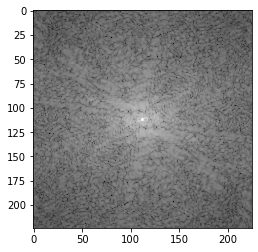

In [12]:
# Now let's plot the log of the magnitude
Fmaglog = np.log(Fmag)
plt.imshow(Fmaglog, cmap="gray")